In [1]:
import inspect
import itertools
import os
import shutil
import sys
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycode_similar
import textdistance
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from test_functions import test_coins, test_decipher

%matplotlib inline

In [2]:
def similar(f1, f2):
    f1_code = inspect.getsource(f1)
    f2_code = inspect.getsource(f2)
    return textdistance.levenshtein(f1_code, f2_code)

def plot_similarity(arr, indices, thr, title='Code similarity'):
    fig, ax = plt.subplots(figsize=(13, 13))
    im = ax.imshow(arr, cmap='hot')

    ax.set_title(title, fontsize=15)
    ax.set_xticks(np.arange(len(indices)))
    ax.set_yticks(np.arange(len(indices)))
    ax.set_yticklabels(indices)
    ax.set_xticklabels(indices, rotation=45)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    plt.colorbar(im, cax)

    for i, j in itertools.product(range(len(indices)), repeat=2):
        if j > i and arr[i, j] < thr:
            ax.text(j, i, '?', color='w', fontsize=20, ha='center', va='center')
            ax.axvline(j, color='k', linestyle=':', alpha=.75)
            ax.axhline(i, color='k', linestyle=':', alpha=.75)

In [3]:
exercises = ['3_1', '3_2']
func_names = ['coins', 'decipher']
tests = {'coins': test_coins, 'decipher': test_decipher}
path_in = 'students/h3'

In [4]:
# Reset output directory
path_out = os.path.join(path_in, 'unpacked')
if os.path.exists(path_out):
    shutil.rmtree(path_out)
    os.mkdir(path_out)

for file in os.listdir(path_in):
    if file.endswith('zip'):
        
        zip_fpath = os.path.join(path_in, file)
        index = file[:6]
        
        with zipfile.ZipFile(zip_fpath, 'r') as zip_obj:
            files = zip_obj.namelist()
            if not any(f'{index}/{e}.py' in files for e in exercises):
                print(file, f'zero correct files found...', files)
                zip_obj.extractall(os.path.join(path_out, index + '_fix'))     
            else:
                zip_obj.extractall(path_out)

296818.zip zero correct files found... ['296818/3.1.py']
305820.zip zero correct files found... ['3_1.py', '3_2.py']
305823.zip zero correct files found... ['3_1.py', '3_2.py']
303222.zip zero correct files found... ['3_2.py', '3_1.py', '__MACOSX/', '__MACOSX/._3_1.py']
305825.zip zero correct files found... ['3.1.py', '3.2.py']
303226.zip zero correct files found... ['3_2.py', '__MACOSX/', '__MACOSX/._3_2.py', '3_1.py', '__MACOSX/._3_1.py']
303228.zip zero correct files found... ['303228/', '303228/3.1.py', '303228/3.2.py']
303211.zip zero correct files found... ['3_1.py', '3_2.py']


In [5]:
path_clean = os.path.join(path_in, 'clean')

functions = {}
errors = []

for index in os.listdir(path_clean):
    
    functions[index] = {}
    
    sys.path.insert(0, os.path.join(os.getcwd(), path_clean, index))
    
    for exercise, func_name in zip(exercises, func_names):
        try:
            imp = __import__(exercise)
            functions[index][func_name] = imp.__dict__[func_name]
        except Exception as err:
            msg = f'error for index {index} and exercise {exercise}: {err}'
            errors.append(msg)
        finally:
            try:
                del sys.modules[exercise]
                del imp
            except:
                pass
    sys.path.pop(0)
    
clear_output()
for error in errors:
    print(error)

error for index 303216 and exercise 3_2: list index out of range
error for index 303226 and exercise 3_2: invalid syntax (3_2.py, line 6)
error for index 296818 and exercise 3_1: expected an indented block (3_1.py, line 3)
error for index 296818 and exercise 3_2: No module named '3_2'
error for index 303215 and exercise 3_1: No module named '3_1'


In [6]:
results = {}
for index, fn_dict in functions.items():
    results[index] = []
    for fn_name in func_names:
        score = tests[fn_name](fn_dict.get(fn_name, None))
        results[index].append(score)

clear_output()

df = pd.DataFrame.from_dict(results, orient='index', columns=func_names)
df['total'] = df.loc[:, func_names].sum(axis=1)
df['total_round'] = round(df['total'] / len(func_names) * 4) / 4
df

,coins,decipher,total,total_round
303243,1.0,1.0,2.0,1.00
303228,1.0,0.8,1.8,1.00
305820,1.0,1.0,2.0,1.00
502770,1.0,1.0,2.0,1.00
303229,0.0,0.8,0.8,0.50
303238,1.0,0.8,1.8,1.00
305823,0.0,0.0,0.0,0.00
303208,0.8,1.0,1.8,1.00
303216,0.0,0.0,0.0,0.00
303237,1.0,0.8,1.8,1.00


In [7]:
similarity = {}
for func_name in func_names:
    similarity[func_name] = np.full((len(functions), len(functions)), np.nan)

indices = list(functions.keys())
for i, j in itertools.product(range(len(indices)), repeat=2):
    if j >= i:
        for func_name in func_names:
            fi = functions[indices[i]].get(func_name)
            fj = functions[indices[j]].get(func_name)
            if fi is not None and fj is not None:
                similarity[func_name][i, j] = similar(fi, fj)

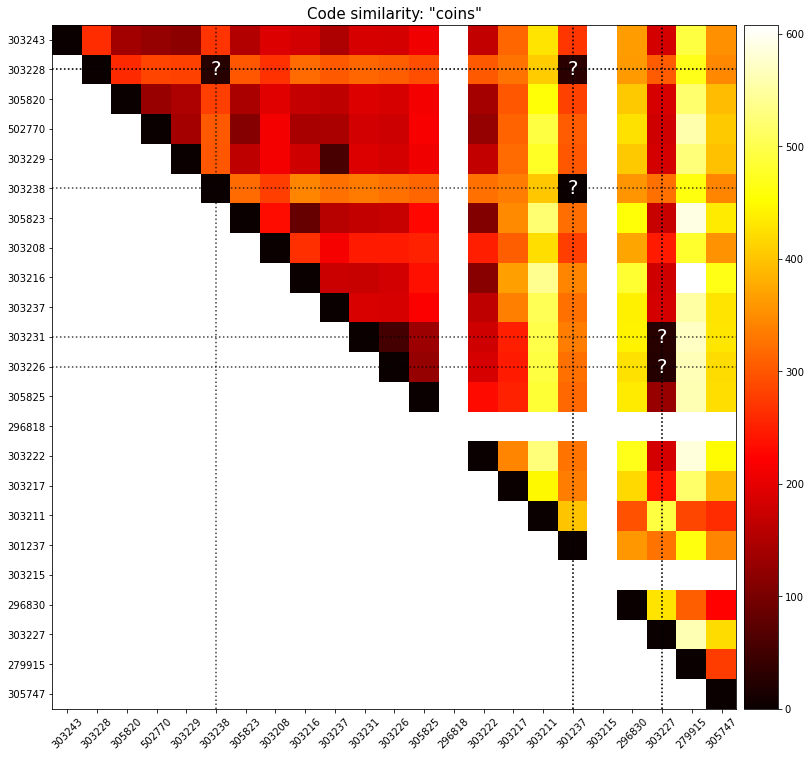

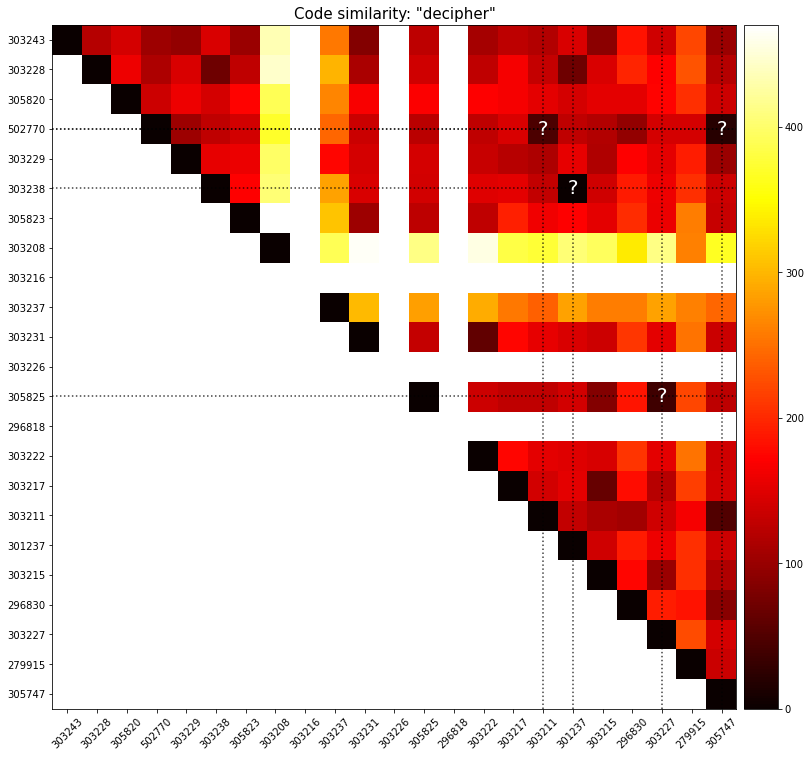

In [8]:
plot_similarity(similarity['coins'], indices, 50,
                title='Code similarity: "coins"')
plot_similarity(similarity['decipher'], indices, 50, 
                title='Code similarity: "decipher"')